In [1]:
import os
import sys
import glob
import argparse
import os, shutil
import matplotlib.pyplot as plt

from os import walk, getcwd
from keras import __version__
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IM_WIDTH, IM_HEIGHT = 299, 299 #fixed size for InceptionV3
nb_epoch = 1
batch_size = 32
FC_SIZE = 1001
nb_classes = 4        # 4 clases
nb_train = 4000       # 1000 x clase
nb_validation = 1200  # 500 x clase
nb_tes = 1200         # 500 x clase

#Asociamos a dataset y carpetas, traim, validation y test
base_dir = 'balanced_dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
loss_mode = 'binary_crossentropy'
output_model_file = 'Xception_FT_model_1.h5'
class_mode= 'categorical'

#inceptionv3_weights = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Retorna todos los archivos de un directorio dado
def ls(ruta):  
    return next(walk(ruta))[2]

In [4]:
from keras.applications import Xception
#Load Pretrained model
conv_base = Xception(include_top=False, 
                     weights='imagenet', 
                     input_shape = (IM_WIDTH, IM_HEIGHT, 3)) 

In [5]:
def setup_to_transfer_learn(model, base_model):
    
  #Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='rmsprop', loss=loss_mode, metrics=['accuracy'])

In [6]:
def add_new_last_layer(base_model, nb_classes):
#"""
#Add last layer to the convnet
#Args:
#  base_model: keras model excluding top
#  nb_classes: # of classes
#Returns:
#  new keras model with last layer
#"""
    FC_SIZE =1001
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(FC_SIZE, activation='relu')(x) #new FC layer, random init
    
    if class_mode == "binary":
        predictions = Dense(1, activation='sigmoid')(x) #new softmax layer
    else:
        predictions = Dense(nb_classes, activation='softmax')(x) #new softmax layer
        
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [7]:
def setup_to_finetune(model):
#"""Freeze the bottom NB_IV3_LAYERS and retrain the remaining top layers.
#note: NB_IV3_LAYERS corresponds to the top 2 inception blocks in the inceptionv3 arch
#Args:
#model: keras model
#"""
    for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
        layer.trainable = False
    for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
        layer.trainable = True
        
    #model.compile(optimizer="rmsprop", loss=loss_mode, metrics=['accuracy'])
    #default values rmsprop
    #rmsprop  keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
#Graficas loss y accuracy
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()
    

In [9]:
#PREPROCESSING - 

train_datagen = ImageDataGenerator(
    rescale = 1./255,              #Normalizamos el valor de pixel
    rotation_range = 40,          #rotamos imagne 40 grados
    width_shift_range =0.2,       #aplica una fracción del ancho de la imagen orig
    height_shift_range =0.2,      #aplica una fracción del alto de la imagen orig
    shear_range = 0.2,            #aplica al azar operaciones de corte
    zoom_range = 0.2,             #aplica zoom aleatorio dentro de las imagenes
    horizontal_flip = True,       #invierte aleatoriamente la mitad de las imágenes
    fill_mode = 'nearest'
) 
test_datagen = ImageDataGenerator(rescale = 1./255)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,              #Normalizamos el valor de pixel
    rotation_range = 40,          #rotamos imagne 40 grados
    width_shift_range =0.2,       #aplica una fracción del ancho de la imagen orig
    height_shift_range =0.2,      #aplica una fracción del alto de la imagen orig
    shear_range = 0.2,            #aplica al azar operaciones de corte
    zoom_range = 0.2,             #aplica zoom aleatorio dentro de las imagenes
    horizontal_flip = True,       #invierte aleatoriamente la mitad de las imágenes
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    class_mode=class_mode #'categorical'
  )

validation_generator = test_datagen.flow_from_directory( #OJO HE CAMBIADO en la prueba 3
    validation_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=batch_size,
    class_mode=class_mode
  )

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size = batch_size, 
    class_mode = class_mode)

Found 4000 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [10]:
#base_model = InceptionV3(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
#model = add_new_last_layer(base_model, nb_classes)

model = add_new_last_layer(conv_base, nb_classes)


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [13]:
#TRANSFERENCIA DE APRENDIZAJE

nb_epoch = 2
setup_to_transfer_learn(model, conv_base)
#model.summary()

history_tl = model.fit_generator(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=nb_train//batch_size,
    validation_data=validation_generator,
    validation_steps= nb_validation//batch_size)


Epoch 1/2
125/125 [==============================] - 98s 781ms/step - loss: 0.5343 - acc: 0.7744 - val_loss: 0.7401 - val_acc: 0.6480
Epoch 2/2
125/125 [==============================] - 90s 721ms/step - loss: 0.3927 - acc: 0.8242 - val_loss: 0.8773 - val_acc: 0.6404


In [14]:
#FINE TUNNING
#NB_IV3_LAYERS_TO_FREEZE=249
#NB_IV3_LAYERS_TO_FREEZE=172
NB_IV3_LAYERS_TO_FREEZE=-0
#NB_IV3_LAYERS_TO_FREEZE=-4
setup_to_finetune(model)

In [15]:
nb_epoch = 30 
history_ft = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train//batch_size,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=nb_validation//batch_size)


Epoch 1/30
125/125 [==============================] - 97s 780ms/step - loss: 0.7421 - acc: 0.7208 - val_loss: 0.5723 - val_acc: 0.7880
Epoch 2/30
125/125 [==============================] - 93s 744ms/step - loss: 0.6048 - acc: 0.7742 - val_loss: 0.5160 - val_acc: 0.8100
Epoch 3/30
125/125 [==============================] - 93s 745ms/step - loss: 0.5313 - acc: 0.7975 - val_loss: 0.4621 - val_acc: 0.8336
Epoch 4/30
125/125 [==============================] - 93s 741ms/step - loss: 0.4865 - acc: 0.8160 - val_loss: 0.4213 - val_acc: 0.8514
Epoch 5/30
125/125 [==============================] - 93s 742ms/step - loss: 0.4606 - acc: 0.8320 - val_loss: 0.3940 - val_acc: 0.8615
Epoch 6/30
125/125 [==============================] - 93s 745ms/step - loss: 0.4294 - acc: 0.8342 - val_loss: 0.3699 - val_acc: 0.8775
Epoch 7/30
125/125 [==============================] - 93s 742ms/step - loss: 0.4036 - acc: 0.8545 - val_loss: 0.3489 - val_acc: 0.8818
Epoch 8/30
125/125 [==============================] - 9

In [16]:
#model.save(output_model_file)
model.save('Xception_FT_model_1.h5')

Graficas Transferencia de aprendizaje de Inception v3 a nuestro Clasificador


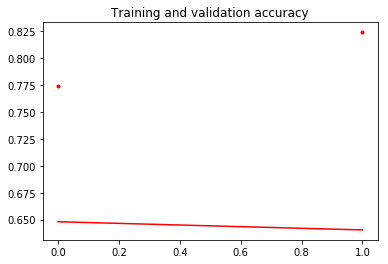

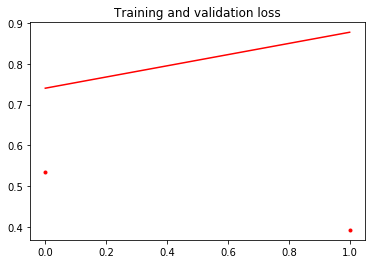

Graficas Fine Tunning


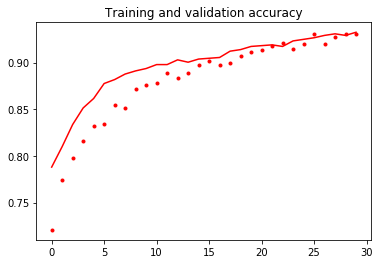

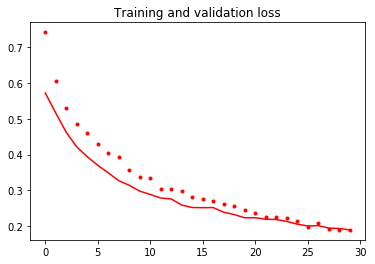

In [17]:
#Graficas Transferencia de Aprendizaje
print('Graficas Transferencia de aprendizaje de Inception v3 a nuestro Clasificador')
plot_training(history_tl)
#Graficas Fine Tunning
print('Graficas Fine Tunning')
plot_training(history_ft)

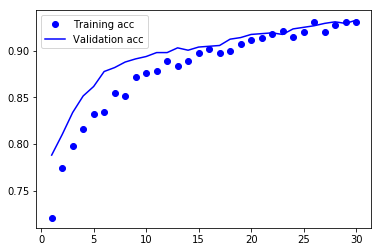

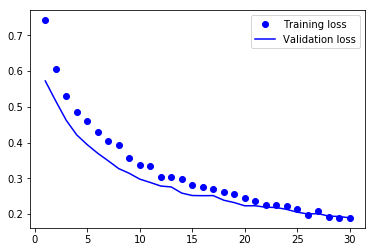

In [18]:
#Mostramos otros graficos 
acc = history_ft.history['acc']
val_acc = history_ft.history['val_acc']
loss = history_ft.history['loss']
val_loss = history_ft.history['val_loss']

epochs = range(1, len(acc)+ 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
#plt.tittle('Trainning and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
#plt.tittle('Trainning and validation loss')
plt.legend()

plt.show()

In [19]:
#Evluamos datos generados del conjunto de datos test
#test_generator = testn_datagen.flow_from_directory(
#    test_dir,   #debemos indicar el directorio de los datos de test
#    target_size = (IM_WIDTH, IM_HEIGHT),
#    batch_size = batch_size, #40 x 50 epocas = 2000
#    class_mode = 'categorical')

model.evaluate_generator(test_generator, steps = 5)

[0.11651783064007759, 0.9625]